In [1]:
import torch
import sys
import os
import random
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import pandas as pd
sys.path.append('../../')
import TD3
import utils

sys.path.append('../')
from common import make_env, perform_action, const_disturb_five, const_jitter_force, get_frame_skip_and_timestep, const_disturb_half
from evals import *



c:\python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
def get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, with_parent_action, penalty):
    for seed in tqdm(range(5)):
        torch.manual_seed(seed)
        np.random.seed(seed)

        timestep = default_timestep if default_timestep <= response_rate else response_rate
        frame_skip = response_rate / timestep
        parent_steps = int(parent_response_rate/response_rate)  # Number children steps in on parent step
        time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
        env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        state_dim = sum(s.shape[0] for s in env.observation_space)
        action_dim = env.action_space.shape[0]
        parent_max_action = float(env.action_space.high[0])
        child_max_action = 2 * parent_max_action
        kwargs = {
            "state_dim": state_dim,
            "action_dim": action_dim,
            "max_action": parent_max_action,
            "discount": discount,
            "tau": tau,
            "observation_space": env.observation_space,
            "delayed_env": delayed_env,
            "reflex": False,
        }
        # Initialize policy
            # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = policy_noise * parent_max_action
        kwargs["noise_clip"] = noise_clip * parent_max_action
        kwargs["policy_freq"] = policy_freq
        parent_policy = TD3.TD3(**kwargs)
        if with_parent_action:
            kwargs["state_dim"] = state_dim + action_dim
        kwargs["max_action"] = child_max_action
        kwargs["policy_noise"] = policy_noise * child_max_action
        kwargs["noise_clip"] = noise_clip * child_max_action
        policy = TD3.TD3(**kwargs)
        arguments = [policy_name, env_name, seed, parent_response_rate, delayed_env, 'best']

        parent_file_name = '_'.join([str(x) for x in arguments])
        parent_policy.load(f"../hybrid/models_paper/{parent_file_name}")
        augment_type = "reflex_train_normal"
        if penalty:
            augment_type += '_penalty'
        if with_parent_action:
            augment_type += '_with_parent_action'

        arguments = [augment_type, policy_name, env_name, seed, response_rate, parent_response_rate, 'best']
        file_name = '_'.join([str(x) for x in arguments])
        policy.load(f"../hybrid/models_paper/{file_name}")
        eval_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        rewards = 0
        actions = 0
        for _ in range(10):
            eval_state, eval_done = eval_env.reset(), False
            eval_parent_action = eval_env.previous_action
            eval_episode_timesteps = 0
            eval_next_parent_action = parent_policy.select_action(eval_state)
            eval_child_state = np.concatenate([eval_state, eval_parent_action], 0) if with_parent_action else eval_state
            while not eval_done:
                
                eval_child_action = policy.select_action(eval_child_state)
                eval_action = (eval_parent_action + eval_child_action).clip(-parent_max_action, parent_max_action)
                if np.all(abs(eval_action - eval_parent_action) <= reflex_threshold):
                    eval_action = eval_parent_action
                    eval_child_action = 0
                    if (eval_episode_timesteps + 1) % parent_steps == 0:
                        actions += 1
                else:
                    actions += 1

                eval_next_state, eval_reward, eval_done, _ = eval_env.step(eval_action)
                eval_state = eval_next_state
                eval_episode_timesteps += 1
                
                if eval_episode_timesteps % parent_steps == 0:
                    eval_next_parent_action = parent_policy.select_action(eval_state)
                elif (eval_episode_timesteps + 1) % parent_steps == 0:
                    eval_parent_action = eval_next_parent_action
                
                eval_child_state = np.concatenate([eval_state, eval_parent_action], 0) if with_parent_action else eval_state
                rewards += eval_reward
        avg_reward = rewards / 10
        avg_actions = actions/10
        dataframe.loc[len(dataframe)] = [env_name, avg_reward, seed, avg_actions, reflex_threshold]

In [40]:
default_timesteps = {'InvertedPendulum-v2':0.02, 'Hopper-v2': 0.002, 'Walker2d-v2': 0.002, 'InvertedDoublePendulum-v2': 0.01, 'Ant-v2': 0.01, 'HalfCheetah-v2': 0.01, 'Reacher-v2': 0.01}
default_frame_skips = {'InvertedPendulum-v2':2, 'Hopper-v2': 4, 'Walker2d-v2': 4, 'InvertedDoublePendulum-v2': 5, 'Ant-v2':5, 'HalfCheetah-v2':5, 'Reacher-v2': 2}
dataframe = pd.DataFrame(columns=["env", "result", "seed", "actions", "threshold"])

delayed_env = True
policy_name = 'TD3'
discount = 0.99
tau=0.005
policy_freq=2
policy_noise=2
noise_clip=0.5
with_parent_action = False

# # inverted pendulum
# env_name = 'InvertedPendulum-v2'
# response_rate = 0.04
# parent_response_rate = 0.08
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# reflex_threshold = 3*0.3
# # for t in range(21):
# #     reflex_threshold = t*0.3
# #     print(reflex_threshold)
# get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, False, True)

# inverted double pendulum
# env_name = 'InvertedDoublePendulum-v2'
# response_rate = 0.05
# parent_response_rate = 0.1
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# reflex_threshold = 3*0.1
# for t in range(11):
#     reflex_threshold = t*0.1
#     print(reflex_threshold)
    
#     get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, False, True)


# # # Hopper
# env_name = 'Hopper-v2'
# response_rate = 0.008
# parent_response_rate = 0.016
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# reflex_threshold = 7*0.1
# # for t in range(11):
# #     reflex_threshold = t*0.1
# #     print(reflex_threshold)
    
# get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, False, True)

# # Walker2d
env_name = 'Walker2d-v2'
response_rate = 0.008
parent_response_rate = 0.016
default_timestep = default_timesteps[env_name]
default_frame_skip = default_frame_skips[env_name]
reflex_threshold = 4*0.1
for t in range(11):
    reflex_threshold = t*0.1
    print(reflex_threshold)
    
    get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold,  True, True)


# # # Ant
# env_name = 'Ant-v2'
# response_rate = 0.05
# parent_response_rate = 0.1
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# reflex_threshold = 4*0.1
# for t in range(11):
#     reflex_threshold = t*0.1
#     print(reflex_threshold)
    
#     get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, True, True)


# # HalfCheetah
# env_name = 'HalfCheetah-v2'
# response_rate = 0.05
# parent_response_rate = 0.1
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# reflex_threshold = 4*0.1
# for t in range(11):
#     reflex_threshold = t*0.1
#     print(reflex_threshold)
    
#     get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, True, True)

0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.73s/it]


0.1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.22s/it]


0.2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]


0.30000000000000004


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.03s/it]


0.4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.77s/it]


0.5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.72s/it]


0.6000000000000001


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


0.7000000000000001


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.59s/it]


0.8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.56s/it]


0.9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.77s/it]


1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.36s/it]


In [30]:
dataframe['return_per_action'] = (dataframe['result'] / dataframe['actions'])

df = dataframe.groupby(['env']).mean()
df_std = dataframe.groupby(['env']).std()
df['std'] = df_std['result']
df

,result,actions,threshold,return_per_action,std
env,,,,,
Hopper-v2,3250.262818,760.34,0.7,4.286378,99.075683
InvertedDoublePendulum-v2,1442.039836,114.52,0.3,11.775033,1459.367420
InvertedPendulum-v2,901.980000,699.40,0.9,1.403529,219.179383
Walker2d-v2,2715.827990,862.50,0.4,3.136845,492.059598


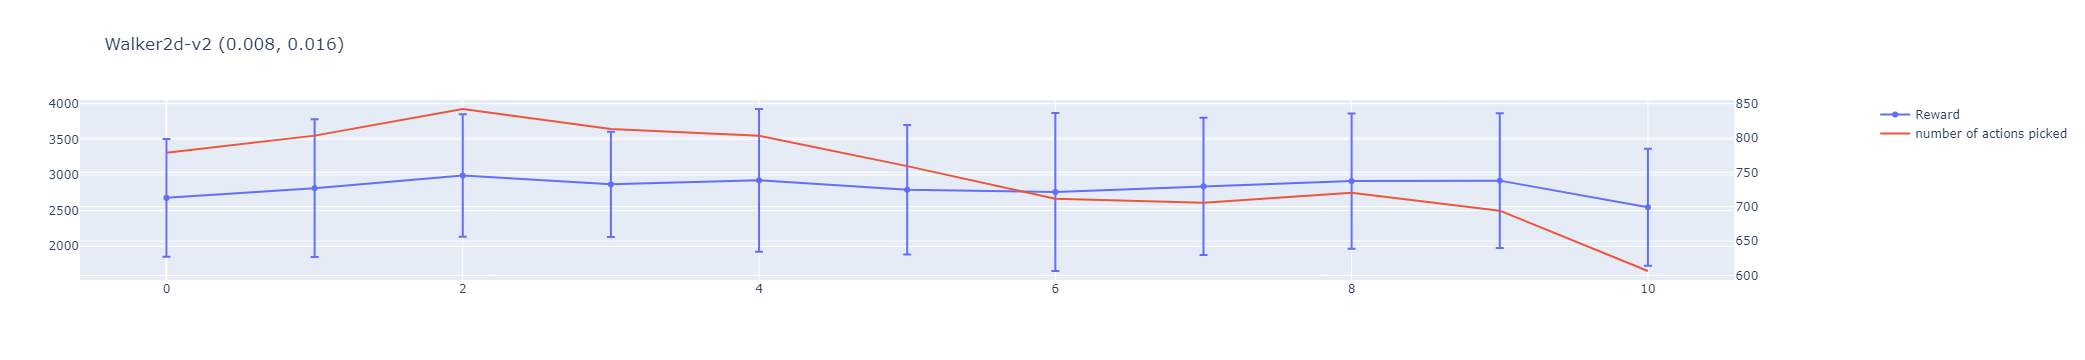

In [41]:
dataf = dataframe #.loc[dataframe['seed']!= 4]
df = dataf.groupby(['threshold']).mean()
df_std =  dataf.groupby(['threshold']).std()
fig = make_subplots(specs=[[{"secondary_y": True}]])


x = list(range(21))

y1_upper = list(df['result'] + df_std['result'])
y1_lower = list(df['result'] - df_std['result'])
y1_lower = y1_lower[::-1]
x_rev = x[::-1]
fig.add_trace(go.Scatter(x=x, y=df['result'], mode='lines+markers', name='Reward', error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=df_std['result'],
            visible=True)), secondary_y=False)

fig.add_trace(go.Scatter(x=list(range(21)), y=df['actions'], mode='lines', name='number of actions picked'), secondary_y=True)
fig.update_layout(
    title_text="Walker2d-v2 (0.008, 0.016)")


In [11]:
for r in df['actions']:
    print(r)

1000.0
522.64
507.14
427.08000000000004
416.3
414.73999999999995
426.62
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0


In [29]:
def get_results(dataframe, default_timestep,  parent_response_rate, env_name):
    for seed in tqdm(range(5)):
        torch.manual_seed(seed)
        np.random.seed(seed)

        timestep = default_timestep
        frame_skip = parent_response_rate / timestep
        time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
        env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        state_dim = sum(s.shape[0] for s in env.observation_space)
        action_dim = env.action_space.shape[0]
        parent_max_action = float(env.action_space.high[0])
        child_max_action = 2 * parent_max_action
        kwargs = {
            "state_dim": state_dim,
            "action_dim": action_dim,
            "max_action": parent_max_action,
            "discount": discount,
            "tau": tau,
            "observation_space": env.observation_space,
            "delayed_env": delayed_env,
            "reflex": False,
        }
        # Initialize policy
            # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = policy_noise * parent_max_action
        kwargs["noise_clip"] = noise_clip * parent_max_action
        kwargs["policy_freq"] = policy_freq
        parent_policy = TD3.TD3(**kwargs)
        arguments = [policy_name, env_name, seed, parent_response_rate, delayed_env, 'best']
        
        parent_file_name = '_'.join([str(x) for x in arguments])
        
        parent_policy.load(f"../hybrid/models_paper/{parent_file_name}")

        eval_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        rewards = 0
        actions = 0
        for _ in range(10):
            eval_state, eval_done = eval_env.reset(), False
            eval_parent_action = eval_env.previous_action
            eval_episode_timesteps = 0
            while not eval_done:
                action = parent_policy.select_action(eval_state)
                actions += 1
                eval_next_state, eval_reward, eval_done, _ = eval_env.step(action)
                eval_state = eval_next_state
                eval_episode_timesteps += 1
                rewards += eval_reward
        avg_reward = rewards / 10
        avg_actions = actions/10
        dataframe.loc[len(dataframe)] = [env_name, avg_reward, seed, avg_actions]

In [30]:

default_timesteps = {'InvertedPendulum-v2':0.02, 'Hopper-v2': 0.002, 'Walker2d-v2': 0.002, 'InvertedDoublePendulum-v2': 0.01, 'Ant-v2': 0.01, 'HalfCheetah-v2': 0.01, 'Reacher-v2': 0.01}
default_frame_skips = {'InvertedPendulum-v2':2, 'Hopper-v2': 4, 'Walker2d-v2': 4, 'InvertedDoublePendulum-v2': 5, 'Ant-v2':5, 'HalfCheetah-v2':5, 'Reacher-v2': 2}
dataframe = pd.DataFrame(columns=["env", "result", "seed", "actions"])

delayed_env = True
policy_name = 'TD3'
discount = 0.99
tau=0.005
policy_freq=2
policy_noise=2
noise_clip=0.5
with_parent_action = False

# # inverted pendulum
# env_name = 'InvertedPendulum-v2'
# parent_response_rate = 0.04
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# get_results(dataframe, default_timestep, parent_response_rate, env_name)

# # # inverted double pendulum
# env_name = 'InvertedDoublePendulum-v2'
# parent_response_rate = 0.05
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# get_results(dataframe, default_timestep, parent_response_rate, env_name)



# # Hopper
# env_name = 'Hopper-v2'
# parent_response_rate = 0.008
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# get_results(dataframe, default_timestep, parent_response_rate, env_name)

# # Walker2d
# env_name = 'Walker2d-v2'
# parent_response_rate = 0.008
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# get_results(dataframe, default_timestep, parent_response_rate, env_name)

# Ant
# env_name = 'Ant-v2'
# parent_response_rate = 0.1
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# get_results(dataframe, default_timestep, parent_response_rate, env_name)

# HalfCheetah
env_name = 'HalfCheetah-v2'
parent_response_rate = 0.05
default_timestep = default_timesteps[env_name]
default_frame_skip = default_frame_skips[env_name]
get_results(dataframe, default_timestep, parent_response_rate, env_name)

# # Reacher
# env_name = 'Reacher-v2'
# parent_response_rate = 0.02
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# get_results(dataframe, default_timestep, parent_response_rate, env_name)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.25s/it]


In [31]:
dataframe['return_per_action'] = (dataframe['result'] / dataframe['actions'])

df = dataframe.groupby(['env']).mean()
df_std = dataframe.groupby(['env']).std()
df['std'] = df_std['result']
df

,result,actions,return_per_action,std
env,,,,
HalfCheetah-v2,4469.353222,1000.0,4.469353,2632.708393


In [94]:
policy_name = 'TD3'
delayed_env = True
response_rate = 0.04
parent_response_rate = 0.08
env_name = 'InvertedPendulum-v2'
lcs1 = np.zeros([5, 200])
lcs2 = np.zeros([5, 200])
for seed in range(5):
    td3_arguments = [policy_name, env_name, seed, response_rate, delayed_env]
    file_name = '_'.join([str(x) for x in td3_arguments])
    lcs1[seed] = np.load(f"../results_paper/{file_name}.npy")
    
    arguments = ["reflex_train_normal_penalty_with_parent_action", policy_name, env_name, seed, response_rate, parent_response_rate]
    
    file_name = '_'.join([str(x) for x in arguments])
    lcs2[seed] = np.load(f"../hybrid/results_paper/{file_name}.npy")
    

In [99]:

lcs1_mean = np.mean(lcs2, 0)

for i in lcs1_mean:
    print(i)

488.71999999999997
504.0
1000.0
454.0
735.5
674.6
821.64
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
911.6200000000001
830.0
1000.0
1000.0
1000.0
1000.0
855.72
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
10